In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import os
os.chdir('/gdrive/My Drive/reddit_india/')

In [0]:
import fastai
from fastai.text import *
from fastai.callbacks import *

In [5]:
df=pd.read_csv('./data.csv')
df.shape

(1800, 12)

In [6]:
df.head(3)

,title,score,id,body,author,flair,url,comms_num,created,comment,authors,combined_features
0,"Lost my Job, Sick Mother and Paralysed Dad, In...",1042,g014wc,Hi....It's really tough time for everyone. I r...,sanand_satwik,AskIndia,https://www.reddit.com/r/india/comments/g014wc...,132,1.586742e+09,I'm a freelancer. Don't listen to the idiots ...,hashedram diabapp xataari Aashayrao sarcrasti...,"Lost my Job, Sick Mother and Paralysed Dad, In..."
1,Why does the government come with a begging bo...,647,fxofyu,"We have floods, terrorist attacks, famines due...",TWO-WHEELER-MAFIA,AskIndia,https://www.reddit.com/r/india/comments/fxofyu...,205,1.586448e+09,I don't understand why they don't use money f...,Kinky-Monk ak32009 fools_eye None DwncstSheep...,Why does the government come with a begging bo...
2,Mother's condition is going worse due to hepat...,756,g0zlly,"Hi folks, I really appreciate the warm respons...",sanand_satwik,AskIndia,https://www.reddit.com/r/india/comments/g0zlly...,92,1.586871e+09,If anyone knows who is influential on Twitter...,AlternativeDrop6 TheRobotsHaveCome lanky32 pl...,Mother's condition is going worse due to hepat...


In [7]:
np.unique(df['flair'],return_counts=True)

(array(['AskIndia', 'Business/Finance', 'Food', 'Non-Political', 'Photography', 'Policy/Economy', 'Politics',
        'Science/Technology', 'Sports'], dtype=object),
 array([200, 200, 200, 200, 200, 200, 200, 200, 200]))

In [8]:
df=df[['flair','title']]
df["flair"].apply(lambda x:str(x))
df.dropna()
df.head()

,flair,title
0,AskIndia,"Lost my Job, Sick Mother and Paralysed Dad, In..."
1,AskIndia,Why does the government come with a begging bo...
2,AskIndia,Mother's condition is going worse due to hepat...
3,AskIndia,Men who are 30+ and have decided not to get ma...
4,AskIndia,"r/India: If money is no bar, would you prefer ..."


In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df)

In [12]:
data_lm = TextLMDataBunch.from_df('.', train,val,text_cols='title',label_cols='flair')
data_lm.save('./tmp/data_lm2.pkl')

In [0]:
# data_lm= load_data(path='./tmp/data_lm2.pkl')

In [15]:
# Classifier model data
data_clas  = TextClasDataBunch.from_df('.', train_df=train,
                                       text_cols='title',label_cols='flair',
                                       valid_df=val,
                                       vocab=data_lm.vocab)
data_clas.save('./tmp/data_clas2.pkl')

In [0]:
# data_clas = load_data('./tmp/data_clas.pkl')

In [0]:
data_clas.show_batch()

In [16]:
list(data_clas.vocab.itos[:10])

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',']

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3,pretrained=True)

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(2, 2E-02,callbacks=[SaveModelCallback(learn, name="best_lm2")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.723994,3.767585,0.329911,00:03
1,4.179744,3.594103,0.339360,00:02


Better model found at epoch 0 with valid_loss value: 3.767585039138794.
Better model found at epoch 1 with valid_loss value: 3.594102621078491.


In [0]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1, 2E-03,callbacks=[SaveModelCallback(learn, name="best_lm2")], moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.415604,3.420162,0.369568,00:03


Better model found at epoch 0 with valid_loss value: 3.4201619625091553.


In [0]:
learn.load('best_lm2')
learn.save_encoder('ft_enc2')

## Classifier model

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc2')
pass

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 2.09E-02


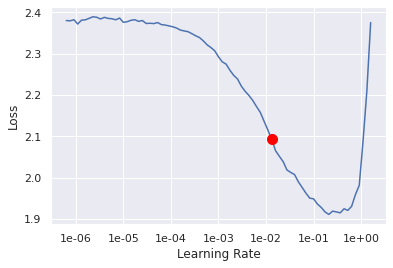

In [33]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [34]:
best_clf_lr = learn.recorder.min_grad_lr
best_clf_lr

0.013182567385564075

In [35]:
learn.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.799365,1.727470,0.431111,00:03


In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, best_clf_lr)


epoch,train_loss,valid_loss,accuracy,time
0,1.643911,1.545555,0.453333,00:03


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.31E-03


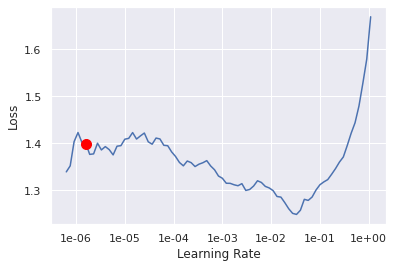

In [38]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [39]:
learn.fit_one_cycle(3, 1E-06,callbacks=[SaveModelCallback(learn, name="best_clf2")])

epoch,train_loss,valid_loss,accuracy,time
0,1.386024,1.520183,0.464444,00:03
1,1.386474,1.519489,0.473333,00:03
2,1.375781,1.517185,0.473333,00:03


Better model found at epoch 0 with valid_loss value: 1.5201832056045532.
Better model found at epoch 1 with valid_loss value: 1.5194886922836304.
Better model found at epoch 2 with valid_loss value: 1.5171854496002197.


In [0]:
learn.load('./best_clf2')
pass

In [42]:
learn.show_results()

text,target,prediction
"xxbos xxmaj xxunk , xxmaj guys ! xxmaj when i xxunk the xxunk & xxunk video , xxunk / xxunk xxunk that i should xxunk "" xxunk xxunk "" with xxunk . i could n't find a xxunk xxunk , but i found what they call "" xxmaj xxunk . "" xxmaj at first , i was n't too xxunk about it , but after i xxunk it , i",Food,AskIndia
"xxbos xxmaj during # xxunk xxmaj all xxmaj india xxunk of xxunk came down to xxunk xxup xxunk . a drop of xxunk xxunk xxup xxunk . xxmaj it was much beyond the xxunk drop of 12 xxup xxunk . xxmaj xxunk a xxunk system , xxunk planning by xxunk & close xxunk by xxunk xxunk no xxunk . | xxup xxunk xxmaj central xxmaj xxunk xxmaj supply xxmaj xxunk",Non-Political,Politics
"xxbos xxmaj my xxmaj xxunk xxmaj xxunk xxup xxunk 's xxunk xxunk xxunk got xxunk during xxunk . xxmaj service xxunk says it can not be xxunk even though i am eligible for "" xxmaj xxunk care support with xxunk xxunk xxunk "" . xxmaj any way i can xxunk just the xxunk , and avoid xxunk xxunk for an entire new xxup xxunk xxunk ?",Science/Technology,Science/Technology
"xxbos xxmaj pakistan xxunk trying to xxunk 200 xxunk - xxmaj around xxunk xxunk of the xxmaj xxunk - e - xxmaj xxunk ( let ) , xxmaj xxunk - e - xxmaj xxunk ( xxunk ) and xxmaj xxunk xxmaj xxunk ( xxup xxunk ) are ready to xxunk into the xxmaj valley , according to xxunk xxunk available to national security xxunk .",Politics,Photography
"xxbos xxmaj if all lights are xxunk off at once it might lead to failure of xxunk . xxmaj all our emergency services will xxunk might take a week 's time to xxunk power . i would appeal to the public to light xxunk without xxunk off lights : xxmaj xxunk xxmaj xxunk , xxmaj maharashtra xxmaj energy xxmaj minister",Politics,Policy/Economy


In [51]:
np.argmax(preds,axis=1)

tensor([8, 4, 6, 7, 5, 7, 3, 5, 5, 5, 3, 7, 7, 4, 4, 7, 6, 1, 7, 6, 0, 3, 3, 5,
        3, 6, 3, 6, 6, 5, 7, 5, 0, 3, 3, 3, 4, 4, 0, 4, 3, 4, 6, 6, 7, 6, 5, 8,
        0, 4, 0, 3, 5, 0, 6, 6, 8, 0, 0, 3, 0, 7, 5, 5, 0, 4, 6, 2, 6, 8, 3, 7,
        8, 6, 1, 7, 3, 4, 3, 6, 6, 6, 4, 6, 4, 5, 7, 8, 0, 0, 6, 8, 0, 6, 4, 7,
        8, 6, 0, 5, 3, 4, 4, 5, 0, 4, 4, 7, 5, 3, 6, 4, 8, 8, 4, 4, 5, 0, 3, 0,
        3, 6, 1, 8, 0, 6, 3, 3, 6, 4, 8, 7, 4, 5, 3, 2, 0, 3, 7, 4, 1, 2, 4, 7,
        3, 3, 0, 0, 0, 0, 0, 6, 0, 2, 3, 4, 3, 4, 3, 5, 3, 4, 0, 5, 4, 5, 6, 8,
        7, 5, 7, 0, 5, 6, 5, 0, 5, 0, 3, 0, 2, 4, 2, 6, 3, 3, 4, 6, 4, 4, 2, 6,
        8, 6, 6, 4, 6, 6, 2, 4, 0, 6, 8, 0, 3, 8, 0, 3, 8, 5, 5, 0, 0, 8, 8, 6,
        0, 4, 5, 6, 6, 0, 0, 3, 0, 3, 6, 1, 6, 5, 7, 8, 0, 5, 1, 4, 5, 0, 4, 0,
        6, 6, 6, 6, 4, 4, 0, 1, 3, 0, 6, 6, 6, 3, 0, 4, 5, 6, 0, 0, 6, 4, 0, 0,
        0, 0, 8, 6, 2, 7, 6, 3, 2, 5, 2, 6, 4, 4, 4, 8, 4, 3, 6, 6, 3, 4, 4, 3,
        3, 3, 0, 0, 4, 6, 6, 5, 1, 0, 5,

## Confusion Matrix

In [0]:
import sklearn

0.45541270766994446


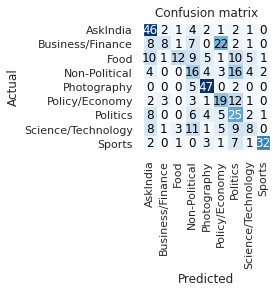

In [53]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
f1=sklearn.metrics.f1_score(y,np.argmax(preds,axis=1),average='weighted')
print (f1)
interp.plot_confusion_matrix()